In [1]:
!git clone https://github.com/locuslab/SATNet
%cd SATNet
!python setup.py develop > install.log 2>&1

Cloning into 'SATNet'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 68 (delta 23), reused 59 (delta 14), pack-reused 0
Unpacking objects: 100% (68/68), done.
/content/SATNet


In [0]:
!wget -cq powei.tw/sudoku.zip && unzip -qq sudoku.zip
!wget -cq powei.tw/parity.zip && unzip -qq parity.zip

In [3]:
import os
import shutil
import argparse
from collections import namedtuple

import numpy as np
import numpy.random as npr

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex, clear_output
import tqdm

if not torch.cuda.is_available(): 
    print('[WARNING] Not using GPU.')
    print('Please select "Runtime -> Change runtime type" and switch to GPU for better performance')
else:
    print('Using', torch.cuda.get_device_name(0))

Using Tesla K80


# Introduction to SATNet
SATNet is a differentiable (smoothed) maximum satisfiability (MAXSAT) solver that can be integrated into the loop of larger deep learning systems.  Our (approximate) solver is based upon a fast coordinate descent approach to solving the semidefinite program (SDP) associated with the MAXSAT problem.

The code below reproduces the Sudoku experiments from our paper "SATNet: Bridging deep learning and logical reasoning using a differentiable satisfiability solver." These experiments show that by integrating the SATNet solver into end-to-end learning systems, we can learn the logical structure of challenging problems in a minimally supervised fashion. In particular, this notebook shows how we can learn to:
* Play **9×9 Sudoku (original and permuted)** solely from examples.
* Solve a **"visual Sudoku"** problem that maps images of Sudoku puzzles to their associated logical solutions. 

For more details and discussion about these experiments, please see the [SATNet paper](https://icml.cc/Conferences/2019/Schedule?showEvent=3947).

In [4]:
import satnet
print('SATNet document\n', satnet.SATNet.__doc__)

SATNet document
 Apply a SATNet layer to complete the input probabilities.

    Args:
        n: Number of input variables.
        m: Rank of the clause matrix.
        aux: Number of auxiliary variables.

        max_iter: Maximum number of iterations for solving
            the inner optimization problem.
            Default: 40
        eps: The stopping threshold for the inner optimizaiton problem.
            The inner Mixing method will stop when the function decrease
            is less then eps times the initial function decrease.
            Default: 1e-4
        prox_lam: The diagonal increment in the backward linear system
            to make the backward pass more stable.
            Default: 1e-2
        weight_normalize: Set true to perform normlization for init weights.
            Default: True

    Inputs: (z, is_input)
        **z** of shape `(batch, n)`: 
            Float tensor containing the probabilities (must be in [0,1]).
        **is_input** of shape `(batch, 

# Building SATNet-based Models
To solve **Sudoku** and a **permuted version of Sudoku**: We construct a SATNet-based SudokuSolver layer that takes as input a logical (bit) representation of the initial Sudoku board along with a mask representing which bits must be learned (i.e. all bits in empty Sudoku cells). This input is vectorized. Given this input, the SudokuSolver layer then outputs a bit representation of the Sudoku board with guesses for the unknown bits.

In [0]:
class SudokuSolver(nn.Module):
    def __init__(self, boardSz, aux, m):
        super(SudokuSolver, self).__init__()
        n = boardSz**6
        self.sat = satnet.SATNet(n, m, aux)

    def forward(self, y_in, mask):
        out = self.sat(y_in, mask)
        del y_in, mask
        return out

To solve **"visual Sudoku"**: We construct a (standard) convolutional neural network for MNIST digit recognition and train it end-to-end with our SudokuSolver layer. This architecture takes in an image representation of a Sudoku board constructed with MNIST digits. Each MNIST digit is classified by the convolutional network, and the resulting (estimated) logical representation of the initial Sudoku board is then fed as input to the SudokuSolver layer. (As described earlier, the SudokuSolver layer then outputs a bit representation of the Sudoku board with guesses for the unknown bits.)

In [0]:
class DigitConv(nn.Module):
    '''
    Convolutional neural network for MNIST digit recognition. From:
    https://github.com/pytorch/examples/blob/master/mnist/main.py
    '''
    def __init__(self):
        super(DigitConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)[:,:9].contiguous()

class MNISTSudokuSolver(nn.Module):
    def __init__(self, boardSz, aux, m):
        super(MNISTSudokuSolver, self).__init__()
        self.digit_convnet = DigitConv()
        self.sudoku_solver = SudokuSolver(boardSz, aux, m)
        self.boardSz = boardSz
        self.nSq = boardSz**2
    
    def forward(self, x, is_inputs):
        nBatch = x.shape[0]
        x = x.flatten(start_dim = 0, end_dim = 1)
        digit_guess = self.digit_convnet(x)
        puzzles = digit_guess.view(nBatch, self.nSq * self.nSq * self.nSq)

        solution = self.sudoku_solver(puzzles, is_inputs)
        return solution

The experimental parameters we use in the paper are below.

In [0]:
from exps.sudoku import train, test, FigLogger, find_unperm
args_dict = {'lr': 2e-3, 
             'cuda': torch.cuda.is_available(), 
             'batchSz': 40,
             'mnistBatchSz': 50,
             'boardSz': 3, # for 9x9 Sudoku
             'm': 600,
             'aux': 300,
             'nEpoch': 100
            }
args = namedtuple('Args', args_dict.keys())(*args_dict.values())

# The Sudoku Datasets
We use and/or create the following datasets:
* **Sudoku:** We generate 10K 9x9 Sudoku boards (9K test/1K train) using code available [here](https://github.com/Kyubyong/sudoku) and represent them via bit (one-hot) representations.
* **Permuted Sudoku:** We apply a fixed permutation to the 10K Sudoku board bit representations generated for the Sudoku experiment.
* **Visual Sudoku:** We construct versions of the 10K Sudoku boards generated for the Sudoku experiment in which each board cell is represented by a (randomly-selected) MNIST digit. (MNIST digits are also split into train/test sets, with train and test MNIST digits applied only to train and test Sudoku boards, respectively.)

The code below reads and processes these datasets for use with the architectures constructed above. A sample Sudoku board, its associated bit representation, and its associated MNIST representation are displayed below.

In [0]:
def process_inputs(X, Ximg, Y, boardSz):
    is_input = X.sum(dim=3, keepdim=True).expand_as(X).int().sign()

    Ximg = Ximg.flatten(start_dim=1, end_dim=2)
    Ximg = Ximg.unsqueeze(2).float()

    X      = X.view(X.size(0), -1)
    Y      = Y.view(Y.size(0), -1)
    is_input = is_input.view(is_input.size(0), -1)

    return X, Ximg, Y, is_input

with open('sudoku/features.pt', 'rb') as f:
    X_in = torch.load(f)
with open('sudoku/features_img.pt', 'rb') as f:
    Ximg_in = torch.load(f)
with open('sudoku/labels.pt', 'rb') as f:
    Y_in = torch.load(f)
with open('sudoku/perm.pt', 'rb') as f:
    perm = torch.load(f)

X, Ximg, Y, is_input = process_inputs(X_in, Ximg_in, Y_in, args.boardSz)
if args.cuda: X, Ximg, is_input, Y = X.cuda(), Ximg.cuda(), is_input.cuda(), Y.cuda()

N = X_in.size(0)
nTrain = int(N*0.9)

sudoku_train = TensorDataset(X[:nTrain], is_input[:nTrain], Y[:nTrain])
sudoku_test =  TensorDataset(X[nTrain:9040], is_input[nTrain:9040], Y[nTrain:9040])
perm_train = TensorDataset(X[:nTrain,perm], is_input[:nTrain,perm], Y[:nTrain,perm])
perm_test =  TensorDataset(X[nTrain:,perm], is_input[nTrain:,perm], Y[nTrain:,perm])
mnist_train = TensorDataset(Ximg[:nTrain], is_input[:nTrain], Y[:nTrain])
mnist_test =  TensorDataset(Ximg[nTrain:], is_input[nTrain:], Y[nTrain:])

In [0]:
def show_sudoku(raw):
    return (torch.argmax(raw,2)+1)*(raw.sum(2).long())

def show_mnist_sudoku(raw):
    A = raw.numpy()
    digits = np.concatenate(np.concatenate(A,axis=1), axis=1).astype(np.uint8)
    linewidth = 2
    board = np.zeros((digits.shape[0]+linewidth*4, digits.shape[1]+linewidth*4), dtype=np.uint8)
    gridwidth = digits.shape[0]//3

    board[:] = 255
    for i in range(3):
        for j in range(3):
            xoff = linewidth+(linewidth+gridwidth)*i
            yoff = linewidth+(linewidth+gridwidth)*j
            xst = gridwidth*i
            yst = gridwidth*j
            board[xoff:xoff+gridwidth, yoff:yoff+gridwidth] = digits[xst:xst+gridwidth, yst:yst+gridwidth]

    #img = Image.fromarray(255-board)
    plt.imshow(255-board, cmap='gray')

# Our dataset
We relabelled the first 30 sudoku in training set and first 2 sudoku in test set. We solved them manually and wrote down the rule index matrix and step order matrix for each sudoku.

In [10]:
rule_label=torch.tensor([
         [0, 0, 1, 1, 2, 2, 1, 2, 0,       #0
         2, 2, 0, 1, 0, 1, 2, 0, 0,
         1, 0, 2, 1, 1, 0, 0, 0, 0,
         2, 1, 2, 0, 0, 2, 2, 0, 1,
         0, 1, 0, 0, 2, 0, 2, 0, 2,
         2, 2, 0, 2, 0, 2, 0, 2, 2,
         0, 1, 0, 2, 1, 0, 1, 1, 1,
         2, 2, 1, 0, 0, 2, 0, 2, 0,
         1, 1, 1, 0, 0, 0, 0, 2, 2],
    
         [2, 0, 2, 2, 0, 0, 0, 1, 0,        #1
         2, 2, 1, 1, 0, 2, 1, 1, 2,
         0, 0, 0, 1, 0, 2, 0, 2, 2,
         1, 2, 1, 0, 1, 0, 0, 0, 0,
         2, 0, 0, 2, 0, 0, 1, 1, 0,
         0, 1, 2, 1, 2, 0, 2, 0, 1,
         2, 0, 2, 0, 0, 1, 0, 1, 0,
         1, 0, 0, 1, 2, 2, 2, 0, 2,
         0, 2, 0, 0, 2, 1, 0, 2, 2],
    
         [1., 1., 0., 2., 1., 2., 2., 1., 0.,        #2
         0., 0., 2., 0., 0., 2., 0., 1., 1.,
         2., 0., 2., 0., 0., 2., 0., 0., 1.,
         0., 0., 0., 1., 1., 2., 1., 1., 0.,
         0., 2., 1., 0., 0., 1., 2., 0., 1.,
         1., 0., 2., 0., 2., 0., 0., 2., 1.,
         1., 0., 0., 1., 0., 2., 0., 2., 0.,
         2., 0., 2., 2., 2., 0., 2., 0., 1.,
         2., 2., 0., 0., 2., 0., 2., 2., 0.],
    
         [0., 0., 2., 2., 2., 0., 2., 0., 1.,        #3
         0., 2., 1., 0., 0., 2., 1., 2., 0.,
         1., 1., 0., 2., 0., 1., 0., 1., 2.,
         2., 2., 0., 1., 2., 0., 1., 2., 0.,
         0., 2., 2., 1., 2., 0., 2., 0., 0.,
         0., 0., 2., 0., 1., 1., 0., 2., 1.,
         0., 0., 2., 1., 0., 1., 2., 2., 2.,
         2., 0., 0., 0., 0., 1., 2., 0., 2.,
         2., 2., 0., 0., 2., 2., 0., 0., 1.],
    
         [2., 2., 2., 2., 0., 1., 2., 0., 0.,       #4
         2., 0., 0., 1., 0., 1., 1., 2., 0.,
         2., 1., 0., 0., 0., 0., 0., 0., 2.,
         2., 2., 0., 2., 0., 1., 0., 0., 2.,
         0., 1., 0., 0., 2., 1., 2., 1., 0.,
         2., 0., 2., 0., 2., 0., 0., 1., 1.,
         2., 0., 2., 2., 2., 0., 1., 0., 0.,
         1., 1., 1., 2., 0., 1., 0., 1., 2.,
         2., 0., 0., 0., 1., 0., 1., 2., 0.],
    
         [1., 0., 0., 2., 1., 2., 1., 1., 0.,       #5
         2., 0., 0., 1., 2., 2., 0., 0., 0.,
         2., 1., 0., 0., 2., 2., 0., 2., 2.,
         2., 0., 2., 1., 0., 0., 2., 0., 1.,
         2., 0., 2., 2., 1., 0., 1., 0., 0.,
         0., 2., 1., 0., 2., 0., 0., 1., 2.,
         2., 2., 0., 2., 2., 0., 0., 1., 0.,
         0., 2., 1., 0., 0., 0., 0., 0., 1.,
         1., 0., 0., 1., 0., 0., 0., 2., 1.],
    
         [2., 0., 0., 0., 0., 1., 2., 0., 2.,       #6
         0., 2., 1., 2., 0., 0., 0., 1., 0.,
         1., 2., 0., 2., 2., 1., 2., 1., 0.,
         0., 0., 2., 0., 1., 0., 0., 1., 0.,
         0., 1., 2., 1., 0., 2., 0., 1., 1.,
         0., 2., 0., 0., 0., 2., 0., 1., 0.,
         0., 0., 2., 2., 2., 1., 2., 0., 2.,
         1., 1., 0., 2., 1., 0., 2., 1., 0.,
         2., 0., 0., 0., 1., 1., 2., 0., 0.],
    
         [0., 2., 0., 2., 1., 2., 0., 0., 0.,      #7
         0., 2., 2., 0., 1., 1., 2., 2., 2.,
         2., 1., 2., 2., 2., 2., 0., 0., 1.,
         0., 1., 2., 2., 0., 0., 2., 0., 2.,
         0., 0., 2., 0., 1., 2., 0., 1., 2.,
         1., 0., 1., 2., 0., 0., 2., 0., 0.,
         0., 0., 2., 2., 1., 0., 0., 2., 0.,
         0., 0., 0., 2., 0., 0., 2., 0., 2.,
         5., 2., 2., 0., 1., 0., 2., 1., 2.],
    
         [2., 0., 1., 2., 0., 2., 2., 0., 1.,     #8
         0., 5., 0., 0., 0., 0., 0., 0., 1.,
         2., 2., 2., 1., 2., 0., 2., 1., 0.,
         2., 0., 0., 1., 5., 0., 1., 2., 5.,
         0., 2., 0., 2., 0., 2., 1., 0., 1.,
         0., 1., 2., 0., 0., 1., 1., 0., 0.,
         2., 0., 0., 0., 1., 2., 1., 2., 0.,
         1., 2., 0., 0., 0., 0., 1., 1., 0.,
         0., 1., 1., 0., 0., 2., 0., 0., 1.],
         
         [0., 2., 1., 0., 0., 2., 2., 1., 2.,     #9
         0., 0., 1., 2., 0., 0., 0., 0., 5.,
         2., 0., 2., 2., 1., 0., 0., 2., 1.,
         0., 2., 0., 0., 0., 2., 1., 1., 1.,
         2., 2., 0., 2., 0., 1., 1., 0., 0.,
         1., 0., 2., 1., 0., 2., 1., 2., 0.,
         2., 0., 0., 0., 2., 0., 2., 0., 1.,
         2., 2., 1., 0., 1., 2., 2., 0., 1.,
         0., 1., 2., 0., 0., 0., 0., 0., 2.],
    
         [2, 1, 2, 0, 2, 0, 1, 1, 0,     #10
         0, 0, 2, 1, 2, 1, 0, 2, 2,
         0, 2, 0, 0, 2, 0, 0, 0, 0,
         0, 0, 2, 0, 0, 1, 2, 2, 0,
         2, 0, 1, 1, 2, 0, 2, 0, 0,
         0, 1, 2, 2, 2, 0, 2, 1, 2,
         2, 2, 0, 0, 2, 0, 0, 1, 2,
         1, 2, 0, 2, 0, 0, 0, 1, 0,
         0, 2, 1, 0, 1, 1, 1, 2, 0],
         
         [1, 1, 2, 0, 0, 0, 0, 2, 1,      #11
         1, 0, 0, 1, 0, 1, 2, 0, 2,
         0, 0, 0, 2, 1, 1, 1, 2, 2,
         2, 2, 0, 0, 1, 2, 1, 0, 0,
         2, 1, 2, 0, 2, 2, 2, 2, 0,
         0, 0, 2, 0, 2, 0, 0, 0, 1,
         1, 0, 0, 2, 2, 2, 2, 0, 2,
         0, 2, 1, 1, 2, 0, 0, 1, 0,
         2, 0, 1, 2, 0, 0, 0, 0, 1],
    
         [0, 2, 2, 0, 1, 0, 0, 1, 0,      #12
         1, 0, 1, 1, 0, 1, 0, 0, 2,
         0, 2, 1, 2, 0, 0, 1, 0, 2,
         1, 1, 0, 0, 0, 1, 0, 0, 1,
         1, 2, 0, 0, 1, 1, 1, 1, 1,
         2, 0, 0, 2, 0, 0, 2, 1, 1,
         0, 1, 1, 1, 2, 2, 0, 1, 0,
         1, 0, 1, 1, 1, 0, 1, 0, 0,
         2, 1, 0, 0, 0, 1, 2, 0, 0],
    
         [1, 1, 0, 2, 0, 0, 0, 1, 0,     #13
         2, 0, 1, 2, 1, 1, 0, 1, 0,
         0, 1, 2, 2, 0, 1, 2, 2, 0,
         1, 0, 1, 1, 1, 0, 0, 0, 2,
         1, 2, 0, 1, 2, 0, 1, 1, 0,
         2, 0, 1, 0, 2, 0, 0, 2, 2,
         0, 2, 0, 1, 2, 1, 2, 1, 2,
         1, 0, 0, 2, 0, 0, 1, 0, 1,
         0, 2, 2, 0, 0, 2, 0, 1, 0],
    
         [0, 1, 1, 0, 0, 0, 1, 2, 0,     #14
         1, 2, 0, 0, 1, 0, 2, 0, 2,
         0, 0, 2, 0, 1, 0, 2, 0, 2,
         0, 2, 2, 2, 2, 1, 0, 1, 0,
         2, 1, 0, 0, 2, 2, 2, 0, 1,
         0, 0, 0, 2, 1, 0, 0, 1, 0,
         1, 0, 0, 1, 2, 0, 1, 0, 1,
         0, 0, 2, 0, 1, 2, 2, 1, 0,
         2, 1, 0, 1, 1, 0, 2, 2, 0],
    
         [1, 0, 0, 2, 0, 1, 0, 1, 2,      #15
         0, 2, 0, 1, 2, 1, 1, 2, 0,
         0, 1, 1, 2, 2, 0, 0, 0, 2,
         1, 0, 1, 1, 0, 0, 1, 0, 2,
         1, 2, 0, 2, 0, 0, 2, 0, 0,
         0, 2, 2, 0, 1, 0, 0, 0, 1,
         2, 0, 0, 2, 1, 0, 2, 1, 2,
         0, 0, 1, 1, 0, 2, 1, 2, 0,
         0, 2, 0, 0, 2, 2, 1, 0, 2],
    
         [1, 1, 2, 0, 0, 2, 1, 0, 1,       #16
         1, 2, 0, 2, 2, 0, 0, 1, 2,
         2, 2, 0, 1, 0, 0, 1, 0, 0,
         0, 0, 2, 2, 0, 1, 0, 2, 1,
         1, 0, 2, 0, 0, 2, 0, 2, 1,
         0, 2, 0, 0, 2, 2, 2, 2, 1,
         2, 1, 0, 1, 0, 1, 0, 0, 0,
         0, 2, 1, 2, 1, 0, 1, 1, 1,
         2, 0, 0, 0, 0, 1, 1, 0, 0],
    
         [0, 1, 2, 0, 2, 1, 0, 2, 1,       #17
         2, 0, 1, 2, 1, 0, 2, 0, 0,
         0, 2, 0, 2, 2, 0, 0, 0, 1,
         0, 1, 0, 0, 2, 2, 1, 0, 0,
         1, 0, 2, 0, 1, 2, 1, 2, 1,
         0, 0, 1, 0, 0, 0, 1, 2, 2,
         0, 2, 0, 1, 0, 2, 0, 0, 1,
         1, 2, 2, 2, 2, 0, 2, 0, 0,
         2, 0, 1, 1, 0, 0, 2, 0, 0],
    
         [0, 1, 1, 0, 0, 2, 2, 0, 2,       #18
         0, 2, 0, 0, 1, 0, 0, 0, 2,
         2, 0, 1, 0, 0, 0, 2, 0, 1,
         0, 2, 0, 1, 0, 1, 1, 0, 2,
         2, 0, 1, 0, 2, 2, 2, 2, 0,
         1, 2, 1, 2, 0, 0, 2, 2, 0,
         1, 2, 0, 2, 1, 0, 0, 0, 2,
         0, 2, 2, 2, 0, 1, 1, 2, 1,
         0, 2, 0, 2, 1, 0, 0, 1, 0],
    
         [2, 0, 2, 0, 2, 2, 0, 1, 1,       #19
         1, 0, 1, 2, 1, 2, 2, 0, 0,
         0, 0, 0, 2, 2, 0, 0, 0, 1,
         2, 0, 2, 1, 0, 2, 2, 0, 1,
         0, 0, 2, 2, 2, 2, 0, 0, 2,
         1, 1, 2, 0, 1, 0, 0, 2, 0,
         0, 0, 0, 2, 0, 0, 1, 0, 2,
         2, 2, 2, 0, 2, 0, 0, 2, 2,
         0, 0, 1, 1, 0, 1, 2, 1, 2],
         
         [2, 0, 2, 0, 0, 1, 0, 0, 2,           #20
          2, 0, 2, 0, 2, 1, 2, 0, 0,
          2, 1, 0, 2, 0, 2, 1, 2, 0,
          2, 1, 0, 0, 1, 2, 0, 1, 2,
          0, 1, 1, 0, 0, 0, 2, 2, 0,
          0, 0, 2, 1, 0, 2, 2, 2, 0,
          2, 2, 0, 0, 0, 0, 2, 0, 0,
          1, 2, 2, 2, 2, 0, 2, 2, 0,
          1, 2, 0, 0, 1, 0, 0, 0, 1],
    
        [2, 0, 2, 0, 1, 0, 2, 0, 0,     #21
         2, 0, 0, 0, 1, 2, 0, 2, 2,
         1, 1, 1, 0, 1, 0, 0, 1, 2,
         1, 2, 2, 1, 0, 1, 0, 2, 1,
         1, 2, 0, 2, 2, 2, 2, 0, 2,
         2, 0, 0, 0, 2, 2, 1, 0, 2,
         0, 2, 2, 1, 2, 0, 0, 0, 2,
         0, 0, 0, 0, 1, 1, 2, 0, 1,
         2, 1, 0, 2, 2, 0, 0, 2, 0 
        ],
        [1, 0, 2, 0, 2, 0, 2, 1, 0,      #22
         1, 2, 0, 2, 2, 0, 0, 2, 0,
         0, 1, 0, 0, 0, 1, 2, 2, 1,
         2, 2, 1, 2, 0, 2, 0, 0, 2,
         2, 0, 2, 0, 1, 0, 2, 0, 0,
         0, 0, 1, 2, 2, 2, 1, 0, 2,
         2, 0, 0, 1, 1, 0, 0, 2, 2,
         0, 0, 0, 0, 2, 0, 1, 0, 2,
         1, 0, 2, 0, 2, 0, 2, 2, 2
        ],
    
        [0, 0, 2, 0, 1, 0, 1, 0, 2,       #23
         0, 2, 2, 2, 2, 1, 0, 1, 2,
         1, 0, 2, 0, 0, 0, 0, 2, 0,
         0, 1, 2, 0, 0, 1, 2, 2, 0,
         1, 0, 0, 0, 0, 2, 2, 0, 2,
         2, 0, 0, 2, 2, 0, 1, 0, 0,
         2, 2, 1, 2, 0, 2, 2, 0, 1,
         2, 0, 0, 1, 2, 0, 0, 2, 2,
         2, 2, 2, 1, 2, 0, 0, 0, 0],
     
        [2, 2, 0, 0, 2, 1, 0, 2, 0,        #24
         0, 2, 1, 2, 2, 0, 0, 0, 2,
         1, 0, 0, 2, 0, 0, 2, 2, 0,
         0, 2, 1, 2, 0, 0, 2, 0, 0,
         2, 0, 1, 0, 0, 2, 0, 1, 2,
         0, 0, 0, 1, 0, 2, 2, 2, 0,
         1, 0, 0, 2, 2, 2, 2, 0, 2,
         2, 1, 2, 1, 1, 1, 0, 0, 0,
         2, 0, 0, 0, 0, 1, 1, 2, 0],
    
        [1,0,0,0,0,2,1,2,2,        #25
         2,2,0,2,2,0,1,2,0,
         0,0,0,2,1,2,2,2,0,
         1,2,1,2,2,0,0,1,0,
         0,1,2,2,0,0,1,0,2,
         0,0,0,1,2,1,2,2,0,
         2,2,1,1,0,2,2,0,2,
         0,0,0,2,0,2,0,2,1,
         1,0,2,2,0,0,0,2,0],
            
        [1,0,0,2,1,0,1,0,2,       #26
        0,2,2,2,0,2,0,2,1,
        0,2,1,0,2,0,2,0,2,
        0,1,2,0,0,0,0,1,1,
        0,2,1,1,1,2,2,0,2,
        2,1,0,2,2,0,0,2,0,
        0,0,2,0,2,1,0,2,0,
        2,2,1,0,2,1,0,0,0,
        0,1,0,2,0,2,0,1,0],
    
        [2,2,0,1,0,0,2,0,0,        #27
        0,0,2,2,2,1,2,1,2,
        1,2,1,0,1,2,0,0,2,
        1,2,2,2,2,0,0,0,1,
        2,0,2,0,1,0,2,1,0,
        0,0,0,2,2,0,1,2,1,
        0,1,2,0,0,1,1,0,2,
        0,0,1,0,2,2,2,2,0,
        0,2,0,2,0,0,1,2,0],
    
        [0,2,2,2,1,0,2,0,0,       #28
        1,2,2,0,2,2,0,1,2,
        1,0,0,0,0,2,2,2,0,
        1,2,2,0,2,0,2,0,0,
        2,2,0,2,1,0,1,2,1,
        0,2,2,2,0,1,0,0,2,
        2,0,1,0,2,1,2,0,0,
        0,2,0,1,0,2,0,2,0,
        2,1,0,2,0,2,0,0,1],
    
        [2, 0, 2, 2, 0, 0, 0, 1, 0,      #29
        0, 0, 1, 0, 2, 0, 0, 2, 0,
        2, 2, 2, 0, 1, 1, 2, 0, 1,
        0, 2, 0, 2, 0, 0, 1, 2, 0,
        1, 0, 2, 0, 0, 2, 2, 1, 0,
        2, 0, 0, 2, 1, 0, 0, 1, 2,
        2, 2, 0, 0, 0, 2, 2, 1, 2,
        1, 0, 2, 1, 2, 2, 0, 2, 2,
        0, 0, 0, 0, 2, 1, 2, 0, 0],
    
        [1, 0, 2, 1, 0, 2, 0, 1, 0,        #30
         0, 2, 2, 2, 1, 0, 2, 2, 0,
         0, 2, 1, 1, 0, 2, 0, 2, 2,
         0, 2, 2, 0, 1, 2, 0, 0, 1,
         0, 0, 1, 0, 2, 0, 0, 1, 0,
         1, 2, 0, 1, 0, 0, 1, 2, 1,
         2, 1, 1, 0, 0, 1, 2, 0, 0,
         0, 1, 2, 1, 2, 0, 0, 0, 2,
         0, 1, 0, 0, 2, 0, 0, 1, 2],
    
        [0, 0, 2, 2, 2, 0, 2, 2, 1,    #31
         2, 2, 0, 0, 1, 1, 1, 0, 0,
         2, 0, 1, 1, 2, 0, 1, 0, 0,
         0, 2, 0, 2, 0, 2, 2, 0, 1,
         1, 0, 0, 0, 2, 1, 2, 0, 0,
         0, 2, 0, 2, 0, 0, 2, 1, 2,
         2, 1, 2, 0, 2, 2, 2, 2, 1,
         1, 0, 1, 2, 0, 1, 0, 0, 0,
         0, 2, 0, 0, 2, 0, 1, 1, 1]
            
])
print(rule_label.shape)

torch.Size([32, 81])


In [0]:
order_label=torch.tensor([
    [ 0.,  0., 38., 37.,  5., 28.,  9.,  7.,  0.,     #0
        14., 13.,  0., 30.,  0., 29.,  8.,  0.,  0.,
        27.,  0., 35., 36., 26.,  0.,  0.,  0.,  0.,
        39., 40., 16.,  0.,  0.,  3., 11.,  0., 20.,
         0., 21.,  0.,  0.,  2.,  0., 17.,  0., 12.,
        41., 43.,  0.,  1.,  0.,  4.,  0., 10., 19.,
         0., 34.,  0., 23., 24.,  0., 18., 33., 25.,
        15., 44., 45.,  0.,  0., 22.,  0., 32.,  0.,
        42., 46., 47.,  0.,  0.,  0.,  0., 31.,  6.],
    
        [ 2.,  0.,  5., 24.,  0.,  0.,  0., 25.,  0.,    #1
         7.,  8.,  9., 30.,  0.,  4., 21., 27.,  1.,
         0.,  0.,  0., 36.,  0., 35.,  0., 26., 22.,
        46., 10., 45.,  0., 43.,  0.,  0.,  0.,  0.,
        41.,  0.,  0., 13.,  0.,  0., 39., 29.,  0.,
         0., 12., 44., 37., 42.,  0., 38.,  0., 28.,
        14.,  0.,  3.,  0.,  0., 20.,  0., 19.,  0.,
        15.,  0.,  0., 32., 31., 23., 16.,  0., 18.,
         0., 11.,  0.,  0., 33., 34.,  0.,  6., 17.],
    
        [29., 27.,  0., 24., 26.,  3.,  6., 31.,  0.,     #2
         0.,  0., 28.,  0.,  0.,  4.,  0., 45., 46.,
        11.,  0.,  1.,  0.,  0., 38.,  0.,  0., 42.,
         0.,  0.,  0., 25., 37., 34., 39., 41.,  0.,
         0., 12., 33.,  0.,  0., 35.,  7.,  0., 40.,
        30.,  0., 32.,  0., 36.,  0.,  0., 43., 44.,
        21.,  0.,  0., 23.,  0., 22.,  0.,  5.,  0.,
        14.,  0., 15.,  9., 13.,  0., 17.,  0., 18.,
        20., 10.,  0.,  0., 16.,  0., 19.,  8.,  0.],
    
        [ 0.,  0.,  6., 22.,  3.,  0., 37.,  0., 38.,          #3
         0., 19.,  8.,  0.,  0., 25., 31., 29.,  0.,
        14., 20.,  0., 24.,  0., 26.,  0., 27., 18.,
        12., 13.,  0., 43., 30.,  0., 42., 17.,  0.,
         0.,  2.,  5., 45., 44.,  0., 41.,  0.,  0.,
         0.,  0.,  7.,  0., 40., 34.,  0.,  4., 39.,
         0.,  0.,  1., 47.,  0., 46., 16., 15., 35.,
        10.,  0.,  0.,  0.,  0., 32., 28.,  0., 21.,
        11.,  9.,  0.,  0., 23., 33.,  0.,  0., 36.],
    
        [19., 20., 17.,  3.,  0., 23.,  1.,  0.,  0.,        #4
        18.,  0.,  0., 40.,  0., 39., 46., 45.,  0.,
        21., 22.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,
        14., 15.,  0.,  5.,  0., 26.,  0.,  0.,  6.,
         0., 16.,  0.,  0., 12., 27., 43., 44.,  0.,
        11.,  0., 13.,  0., 10.,  0.,  0., 28.,  7.,
        32.,  0.,  8., 34., 37.,  0., 41.,  0.,  0.,
        33., 24., 25., 35.,  0., 30.,  0., 36.,  2.,
        31.,  0.,  0.,  0., 38.,  0., 42.,  9.,  0.],
    
        [44.,  0.,  0., 34., 41., 37., 28., 30.,  0.,         #5
        43.,  0.,  0., 35., 39., 38.,  0.,  0.,  0.,
        42., 13.,  0.,  0., 40., 36.,  0., 29., 24.,
         3.,  0.,  7., 31.,  0.,  0., 26.,  0., 25.,
         5.,  0.,  6., 32., 33.,  0., 27.,  0.,  0.,
         0.,  4.,  8.,  0., 15.,  0.,  0., 23., 22.,
         2., 10.,  0., 16., 14.,  0.,  0., 18.,  0.,
         0., 11.,  9.,  0.,  0.,  0.,  0.,  0., 19.,
        12.,  0.,  0., 17.,  0.,  0.,  0., 20., 21.],
    
        [11.,  0.,  0.,  0.,  0., 15.,  2.,  0.,  4.,          #6
         0., 20., 19.,  3.,  0.,  0.,  0., 21.,  0.,
        38., 37.,  0., 14., 24., 25., 22., 23.,  0.,
         0.,  0.,  9.,  0., 28.,  0.,  0., 29.,  0.,
         0., 10.,  6., 13.,  0., 26.,  0., 30., 17.,
         0.,  8.,  0.,  0.,  0., 27.,  0., 31.,  0.,
         0.,  0., 18.,  5., 35., 36., 34.,  0., 16.,
        41., 39.,  0.,  7., 42.,  0., 33., 32.,  0.,
        40.,  0.,  0.,  0., 44., 43.,  1.,  0.,  0.],
    
        [ 0.,  4.,  0.,  9., 37., 36.,  0.,  0.,  0.,         #7
         0., 39., 38.,  0., 43., 44., 20., 21., 34.,
        23., 40., 22.,  3., 41., 42.,  0.,  0., 35.,
         0., 46., 33.,  8.,  0.,  0.,  2.,  0.,  6.,
         0.,  0.,  5.,  0., 32., 31.,  0., 13., 12.,
        47.,  0., 45.,  7.,  0.,  0., 11.,  0.,  0.,
         0.,  0., 27.,  1., 28.,  0.,  0., 18.,  0.,
         0.,  0.,  0., 10.,  0.,  0., 17.,  0., 15.,
        25., 26., 24.,  0., 30.,  0., 16., 19., 14.],
    
         [ 3.,  0., 11., 12.,  0.,  7., 14.,  0., 15.,         #8
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,
         8.,  9., 10., 13.,  2.,  0., 16., 17.,  0.,
        19.,  0.,  0., 30.,  4.,  0., 36., 18., 34.,
         0., 21.,  0., 29.,  0., 24., 37.,  0., 35.,
         0., 28., 22.,  0.,  0., 27., 38.,  0.,  0.,
        39.,  0.,  0.,  0.,  5., 23., 42., 41.,  0.,
        40., 20.,  0.,  0.,  0.,  0., 43., 44.,  0.,
         0., 32., 31.,  0.,  0., 26.,  0.,  0., 33.],
    
         [ 0., 10., 39.,  0.,  0.,  6.,  1., 41., 40.,        #9
         0.,  0.,  9.,  5.,  0.,  0.,  0.,  0.,  8.,
        27.,  0., 38.,  4.,  7.,  0.,  0., 42., 43.,
         0., 31.,  0.,  0.,  0., 24., 37., 45., 44.,
        33., 32.,  0., 29.,  0., 25., 36.,  0.,  0.,
        34.,  0., 26., 30.,  0., 23., 35., 28.,  0.,
        15.,  0.,  0.,  0., 12.,  0., 17.,  0., 18.,
         2., 11., 20.,  0., 14., 13., 16.,  0., 19.,
         0., 22., 21.,  0.,  0.,  0.,  0.,  0.,  3.],
    
         [10, 24, 23,  0,  4,  0, 40, 41,  0,           #10
          0,  0, 11, 35, 42, 43,  0, 31, 30,
          0, 22,  0,  0, 21,  0,  0,  0,  0,
          0,  0,  3,  0,  0, 16, 15,  9,  0,
         13,  0, 26, 34, 33,  0, 28,  0,  0,
          0, 25,  1,  8, 14,  0, 38, 39, 32,
         2, 18,  0,  0,  7,  0,  0, 20,  5,
         17,  6,  0, 27,  0,  0,  0, 36,  0,
         0, 12, 19,  0, 44, 45, 37, 29,  0],
    
         [45, 46, 18,  0,  0,  0,  0, 14, 39,          #11
         44,  0,  0, 43,  0, 42,  8,  0, 38,
          0,  0,  0, 15, 40, 41, 37,  5, 19,
         17, 10,  0,  0, 31, 12, 32,  0,  0,
         35, 36, 11,  0,  1, 16, 33,  9,  0,
          0,  0, 23,  0, 30,  0,  0,  0, 34,
         22,  0,  0, 20,  6, 21,  3,  0, 13,
          0,  2, 27, 29, 28,  0,  0, 24,  0,
          7,  0, 26,  4,  0,  0,  0,  0, 25],
    
          [ 0,  8,  5,  0, 17,  0,  0, 16,  0,          #12
         19,  0, 20, 21,  0, 22,  0,  0, 14,
          0, 13, 18,  7,  0,  0, 15,  0,  3,
         35, 36,  0,  0,  0, 37,  0,  0, 31,
         34,  4,  0,  0, 23, 33, 27, 28, 32,
         12,  0,  0,  1,  0,  0,  6, 29, 30,
          0, 40, 42, 45, 11, 10,  0, 26,  0,
         41,  0, 43, 44, 24,  0, 25,  0,  0,
          9, 39,  0,  0,  0, 38,  2,  0,  0],
    
          [41, 39,  0,  4,  0,  0,  0, 43,  0,        #13
         14,  0, 40, 32, 36, 30,  0, 42,  0,
          0, 38,  8,  1,  0, 29, 13,  9,  0,
         48,  0, 44, 45, 37,  0,  0,  0,  6,
         47,  7,  0, 46, 33,  0, 27, 28,  0,
         34,  0, 35,  0, 31,  0,  0, 12, 18,
          0, 15,  0, 25,  5, 21,  2, 24, 10,
         26,  0,  0, 16,  0,  0, 23,  0, 19,
          0,  3, 11,  0,  0, 20,  0, 22,  0],
    
          [ 0, 26, 18,  0,  0,  0, 24, 21,  0,        #14
         27, 22,  0,  0,  2,  0, 17,  0, 11,
          0,  0, 10,  0,  1,  0, 23,  0, 12,
          0,  5, 15,  7, 31, 42,  0, 43,  0,
         28, 29,  0,  0, 30, 16,  4,  0, 32,
          0,  0,  0,  6, 41,  0,  0, 44,  0,
         36,  0,  0, 38, 14,  0, 25,  0, 33,
          0,  0,  3,  0, 35, 19,  9, 34,  0,
          8, 37,  0, 39, 40,  0, 20, 13,  0],
    
          [35,  0,  0, 27,  0, 43,  0, 44,  7,         #15
          0, 26,  0, 46, 14, 42, 45, 36,  0,
          0, 31, 32,  3,  6,  0,  0,  0, 20,
         34,  0, 33, 41,  0,  0, 24,  0,  8,
         25,  2,  0, 13,  0,  0,  1,  0,  0,
          0, 12, 21,  0, 23,  0,  0,  0, 22,
          4,  0,  0, 37, 29,  0, 18, 38, 16,
          0,  0, 11, 40,  0,  5, 39,  9,  0,
          0, 10,  0,  0, 28, 15, 30,  0, 17],
    
          [42, 29,  9,  0,  0,  6, 40,  0, 43,       #16
         41, 18,  0, 11, 13,  0,  0, 44, 24,
          7, 23,  0, 14,  0,  0, 30,  0,  0,
          0,  0,  3,  1,  0, 35,  0, 17, 36,
         20,  0, 19,  0,  0, 26,  0, 12, 37,
          0,  2,  0,  0, 10, 34, 25,  4, 38,
         27, 28,  0, 15,  0, 31,  0,  0,  0,
          0, 22, 21,  5, 16,  0, 39, 45, 46,
          8,  0,  0,  0,  0, 32, 33,  0,  0],
    
          [ 0, 25, 10,  0, 21, 20,  0, 11, 26,      #17
         12,  0, 23,  9, 22,  0,  2,  0,  0,
          0, 24,  0,  5, 16,  0,  0,  0, 27,
          0, 39,  0,  0, 13,  7, 40,  0,  0,
         38,  0, 41,  0, 19,  1, 43,  6, 32,
          0,  0, 42,  0,  0,  0, 44,  3, 14,
          0,  8,  0, 33,  0, 18,  0,  0, 31,
         37,  4, 36, 15, 28,  0, 30,  0,  0,
         17,  0, 35, 34,  0,  0, 29,  0,  0],
    
         [ 0, 43, 44,  0,  0, 10,  6,  0, 24,      #18
         0,  1,  0,  0, 21,  0,  0,  0,  5,
         23,  0, 27,  0,  0,  0, 16,  0, 25,
          0, 28,  0, 19,  0, 40, 39,  0,  3,
          2,  0, 34,  0, 29, 13, 18,  7,  0,
         42, 14, 45, 17,  0,  0, 35, 20,  0,
         41, 37,  0,  8, 33,  0,  0,  0, 15,
          0,  9, 22,  4,  0, 36, 38, 30, 26,
          0, 11,  0, 12, 32,  0,  0, 31,  0],
    
          [ 5,  0, 10,  0, 15,  6,  0, 27, 28,      #19
         37,  0, 40,  4, 46, 45, 20,  0,  0,
          0,  0,  0,  9, 38,  0,  0,  0, 29,
         31,  0, 34, 42,  0, 12,  2,  0, 33,
          0,  0,  3, 39, 41, 19,  0,  0, 32,
         35, 24,  7,  0, 36,  0,  0, 11,  0,
          0,  0,  0, 17,  0,  0, 23,  0,  8,
         21, 14, 18,  0, 30,  0,  0, 25,  1,
          0,  0, 22, 43,  0, 44, 13, 26, 16],
    
         [3,0,5,0,0,34,0,0,8,         #20
         11,0,19,0,2,41,31,0,0,
         15,30,0,10,0,24,40,7,0,
         13,43,0,0,35,22,0,39,33,
         0,44,27,0,0,0,38,23,0,
         0,0,9,29,0,16,6,1,0,
         28,4,0,0,0,0,17,0,0,
         37,12,14,20,18,0,26,32,0,
         42,21,0,0,25,0,0,0,36],
     
         [4,0,19,0,26,0,13,0,0,        #21
         2,0,0,0,31,12,0,8,5,
         48,47,37,0,32,0,0,33,18,
         44,20,22,38,0,41,0,29,43,
         46,45,0,30,9,23,7,0,42,
         25,0,0,0,3,17,34,0,24,
         0,27,1,36,6,0,0,0,14,
         0,0,0,0,39,40,10,0,28,
         11,35,0,15,16,0,0,21,0],
    
         [35,0,10,0,27,0,21,37,0,       #22
         22,15,0,11,4,0,0,1,0,
         0,30,0,0,0,36,26,13,38,
         31,24,40,2,0,28,0,0,7,
         29,0,17,0,42,0,9,0,0,
         0,0,41,6,23,16,39,0,32,
         3,0,0,19,44,0,0,33,25,
         0,0,0,0,5,0,45,0,12,
         43,0,8,0,34,0,18,14,20],
    
         [0,0,7,0,31,0,39,0,4,        #23
         0,3,20,6,30,40,0,41,17,
         35,0,25,0,0,0,0,11,0,
         0,36,13,0,0,32,2,16,0,
         42,0,0,0,0,15,8,0,23,
         24,0,0,18,1,0,27,0,0,
         10,21,43,34,0,28,12,0,38,
         33,0,0,44,22,0,0,9,29,
         5,26,19,37,14,0,0,0,0],
    
         [20,28,0,0,3,33,0,10,0,       #24
         0,11,32,24,17,0,0,0,27,
         23,0,0,19,0,0,8,16,0,
         0,25,39,7,0,0,15,0,0,
         5,0,37,0,0,12,0,34,9,
         0,0,0,29,0,2,26,6,0,
         41,0,0,13,4,22,18,0,1,
         38,40,21,36,31,42,0,0,0,
         14,0,0,0,0,43,35,30,0],
    
         [30,0,0,0,0,1,34,16,7,      #25
         19,10,0,33,27,0,39,32,0,
         0,0,0,8,38,29,14,20,0,
         47,3,46,13,17,0,0,35,0,
         0,22,18,28,0,0,40,0,12,
         0,0,0,43,23,42,24,6,0,
         36,9,44,41,0,21,31,0,4,
         0,0,0,26,0,15,0,2,37,
         45,0,11,5,0,0,0,25,0],
    
         [43,0,0,2,44,0,27,0,36,     #26
         0,29,35,18,0,10,0,22,39,
         0,24,41,0,28,0,17,0,11,
         0,42,5,0,0,0,0,26,40,
         0,13,37,23,34,20,4,0,31,
         30,33,0,7,19,0,0,12,0,
         0,0,8,0,15,25,0,3,0,
         14,38,45,0,6,32,0,0,0,
         0,21,0,9,0,1,0,16,0],
    
         [28,4,0,33,0,0,6,0,0,     #27
         0,0,26,14,29,39,36,44,19,
         34,16,40,0,42,5,0,0,38,
         23,20,10,17,8,0,0,0,30,
         12,0,3,0,43,0,18,35,0,
         0,0,0,2,13,0,46,22,47,
         0,41,27,0,0,24,45,0,37,
         0,0,32,0,15,9,1,11,0,
         0,25,0,21,0,0,31,7,0],
    
         [0,33,24,39,40,0,13,0,0,    #28
         44,43,9,0,18,5,0,37,32,
         28,0,0,0,0,6,4,23,0,
         46,11,2,0,38,0,17,0,0,
         31,29,0,3,47,0,19,10,36,
         0,20,15,30,0,41,0,0,25,
         16,0,27,0,14,35,7,0,0,
         0,1,0,42,0,34,0,12,0,
         21,45,0,8,0,22,0,0,26],
    
         [24,0,34,11,0,0,0,36,0,     #29
         0,0,35,0,7,0,0,26,0,
         19,6,14,0,39,40,16,0,33,
         0,13,0,21,0,0,37,2,0,
         18,0,9,0,0,12,4,20,0,
         1,0,0,17,28,0,0,31,8,
         41,25,0,0,0,10,32,42,23,
         43,0,5,38,30,29,0,15,3,
         0,0,0,0,22,44,27,0,0],
    
         [40,0,3,43,0,26,0,45,0,      #30
         0,33,32,18,38,0,24,9,0,
         0,25,42,44,0,37,0,17,2,
         0,4,16,0,20,8,0,0,7,
         0,0,13,0,27,0,0,35,0,
         28,10,0,34,0,0,5,19,12,
         14,31,6,0,0,39,21,0,0,
         0,22,11,29,1,0,0,0,36,
         0,41,0,0,15,0,0,30,23],
    
         [ 0,  0, 27, 13,  4,  0, 34,  8, 35,      #31
          3, 18,  0,  0, 37, 26, 38,  0,  0,
         12,  0, 28, 33, 36,  0, 39,  0,  0,
          0, 15,  0,  7,  0,  5,  9,  0, 17,
         16,  0,  0,  0, 24, 25,  1,  0,  0,
          0,  6,  0, 23,  0,  0, 40, 42, 41,
         29, 19, 31,  0, 14, 10, 44,  2, 46,
         30,  0, 32, 21,  0, 22,  0,  0,  0,
          0, 11,  0,  0, 20,  0, 45, 43, 47]
])

# Our code
* **show_prediction:**  transform the output of satnet model back to normal sudoku. Translate bit representation to numbers 1-9.
* **compare_results:**  Compare the prediction to the actual solved sudoku. It's easy to see which numbers this prediction got right. Therefore we can conclude a solving order by satnet.

In [0]:
def show_prediction(raw):
  
  # input: raw, 1*729 matrix, each number is 0 or 1. The output of satnet model in bit representation.
  # output: python list, 9*9, the actual sudoku board that predicted by satnet model.
  
  i=-1
  j=-1
  res=[[0]*9 for i in range(9)]
  for k in range(729):
    if k%81==0:
      i+=1
    if k%9==0:
      j=(j+1)%9
      h1=k%9
      h2=raw[k].item()
    if raw[k].item()>h2:
      h2=raw[k].item()
      h1=k%9
    if k%9==8:
      res[i][j]=h1+1
  return res

def compare_results(inputt,x,outputt):
  
  '''
  input: inputt is the initial sudoku of the first sample in test set, X_in[9000]. x is predicted sudoku board, 9*9, given by function show_prediction.
         outputt is the solver sudoku of X_in[9000], which is Y_in[9000].
  output: output a 9*9 python list matrix res. If the number in x is predicted correctly, then we set the corresponding position in res as the same value.
          If the number is wrong or given, we set the corresponding position in res 0.
  '''

  res=[[0]*9 for i in range(9)]
  for i in range(9):
    for j in range(9):
      if inputt[i][j]==0 and  x[i][j]==outputt[i][j]:
        res[i][j]=x[i][j]
  return res

## Sudoku

In [15]:
print(show_sudoku(Y_in[9000]))

tensor([[9, 4, 1, 5, 8, 3, 7, 6, 2],
        [3, 6, 5, 2, 9, 7, 4, 1, 8],
        [2, 8, 7, 1, 4, 6, 5, 3, 9],
        [8, 3, 4, 9, 7, 2, 6, 5, 1],
        [1, 2, 9, 3, 6, 5, 8, 4, 7],
        [5, 7, 6, 8, 1, 4, 9, 2, 3],
        [6, 5, 2, 7, 3, 8, 1, 9, 4],
        [4, 1, 8, 6, 2, 9, 3, 7, 5],
        [7, 9, 3, 4, 5, 1, 2, 8, 6]])


inputt is the first sudoku in test set, X_in[9000].

outputt is the solution of inputt.

In [0]:
inputt=[[9, 0, 1, 5, 0, 3, 0, 6, 0],
        [3, 6, 0, 2, 0, 0, 0, 1, 8],
        [2, 0, 7, 0, 4, 6, 0, 0, 9],
        [0, 0, 4, 0, 7, 2, 0, 5, 0],
        [1, 0, 9, 3, 0, 0, 8, 4, 0],
        [0, 7, 0, 8, 0, 0, 9, 0, 0],
        [6, 5, 0, 0, 0, 0, 0, 0, 4],
        [4, 0, 8, 0, 0, 9, 3, 7, 0],
        [0, 0, 0, 0, 5, 1, 2, 0, 0]]

outputt=[[9, 4, 1, 5, 8, 3, 7, 6, 2],
        [3, 6, 5, 2, 9, 7, 4, 1, 8],
        [2, 8, 7, 1, 4, 6, 5, 3, 9],
        [8, 3, 4, 9, 7, 2, 6, 5, 1],
        [1, 2, 9, 3, 6, 5, 8, 4, 7],
        [5, 7, 6, 8, 1, 4, 9, 2, 3],
        [6, 5, 2, 7, 3, 8, 1, 9, 4],
        [4, 1, 8, 6, 2, 9, 3, 7, 5],
        [7, 9, 3, 4, 5, 1, 2, 8, 6]]

## One-hot encoded Boolean Sudoku

In [0]:
print(X[0])

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 

## MNIST Sudoku

# The 9x9 Sudoku Experiment
The results for our 9x9 Sudoku experiment are below. In this experiment, we:
* **Input** a logical (bit) representation of the initial (unsolved) Sudoku board along with a mask representing which bits must be learned (i.e. all bits in empty Sudoku cells). This input is vectorized, which means that our SATNet model cannot exploit the locality structure of the input Sudoku grid when learning to solve puzzles.
* **Output** a bit representation of the Sudoku board with guesses for the unknown bits.

* **Our modifications:**  We printed out the prediction for the first sudoku in test set after each epoch. With two functions show_prediction and compare_results, we can easily see which numbers this prediction got right. After we printed out every 


TESTING SET RESULTS: Average loss: 0.5051 Err: 1.0000


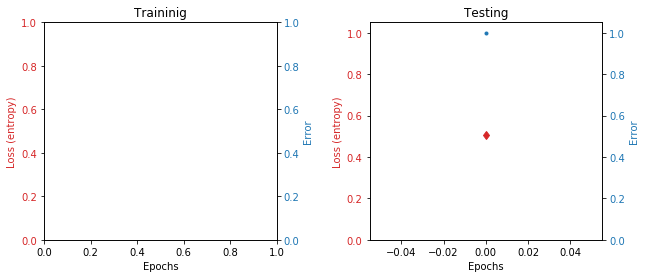

KeyboardInterrupt: ignored

In [16]:
sudoku_model = SudokuSolver(args.boardSz, args.aux, args.m)
if args.cuda: sudoku_model = sudoku_model.cuda()

plt.ioff()
optimizer = optim.Adam(sudoku_model.parameters(), lr=args.lr)

fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.4)
train_logger = FigLogger(fig, axes[0], 'Traininig')
test_logger = FigLogger(fig, axes[1], 'Testing')

test(args.boardSz, 0, sudoku_model, optimizer, test_logger, sudoku_test, args.batchSz)
plt.pause(0.01)
for epoch in range(1, args.nEpoch+1):
    train(args.boardSz, epoch, sudoku_model, optimizer, train_logger, sudoku_train, args.batchSz)
    test(args.boardSz, epoch, sudoku_model, optimizer, test_logger, sudoku_test, args.batchSz)
    display(fig)
    '''
    In our code, aa is the first batch of sudoku in test set. bb is the mask of sudoku in aa.
    cc is the prediction of the first sudoku in aa, transformed back to originak board.
    dd is the compare result of cc and expected result.
    '''
    aa=X[9000:9040]
    bb=is_input[9000:9040]
    cc=show_prediction(sudoku_model.forward(aa,bb)[0])
    print(cc)
    dd=compare_results(inputt,cc,outputt)
    print(dd[0])
    print(dd[1])
    print(dd[2])
    print(dd[3])
    print(dd[4])
    print(dd[5])
    print(dd[6])
    print(dd[7])
    print(dd[8])


# Rule Prediction using SATNet
After we got the SATNet model for solving digital sudoku with decent accuracy, we want to make rule predictions for each number that are not given at the beginning.From solving sudoku ourselves, we summarized two rules: sole candidate and unique candidate. There is detailed explaination in our final report about these two rules. so for each number, we want to predict it's predicted by which rule.


*   Transform1 is the normal way to translate rule index 1 and 2 to bit representation.We represent rule 1 by 1,0,0,0,0,0,0,0,0, rule 2 by 0,2,0,0,0,0,0,0,0.
*   Function transform2 uses the same way to translate rule index with transform1. The difference is transform2 keeps all initial numbers instead of setting them all to 0.
*   Function transform22 translate bit representation back to rule index matrix. 0 means the number is given initially. 1 means this number is decided by rule 1, sole candidate. 2 means this number is decided by rule 2:unique candidate.
*   Function transform3 uses another way to translate 1 and 2. It set 1 to 1,1,1,1,0,0,0,0,0, set 2 to 0,0,0,0,0,1,1,1,1. We tried this because we want to include as many parameters as we can when training.

At the end, we concluded transform2 is better way to translate rule index for rule prediction. So we used transform2 to define the training and testing data set, and transfrom22 to translate the output back.



In [0]:
def transform1(raw):
  
  # input:n*9*9 tensor matrix, n is the number of samples,each number is in [0,1,2]
  # output: n*729 tensor matrix, each number is 0,1, bit representation
  
  n=len(raw)
  res=torch.zeros(n,729)
  for i in range(n):
    for j in range(81):
      if raw[i][j].item()==1:
        res[i][9*j]=1
      if raw[i][j].item()==2:
        res[i][9*j+1]=1
  return res

In [0]:
def transform2(raw,X):
  
  # input:raw is a n*9*9 tensor matrix, n is the number of samples,each number is in [0,1,2]
  #       X is the original matrices.
  # output: n*729 tensor matrix, each number is 0,1, bit representation
  
  n=len(raw)
  res=torch.zeros(n,729)
  for i in range(n):
    for j in range(81):
      if raw[i][j].item()==1:
        res[i][9*j]=1
      if raw[i][j].item()==2:
        res[i][9*j+1]=1
  for i in range(n):
    for j in range(729):  
      if X[i][j].item()==1:
        res[i][j]=1
  return res

def transform22(m,mask):
  
  # input: m is the bit representation result, 1*729 tensor matrix
  #        mask is the corresponding mask for this sudoku
  # output: 9*9 python matrix, each number is in [0,1,2], indicating the rule prediction.
  
  i=-1
  j=-1
  res=torch.zeros(9,9)
  for k in range(729):
    if k%81==0:
      i+=1
    if k%9==0:
      j=(j+1)%9
      if mask[k].item()==0 and mask[k+1].item()==0:
        if m[k].item()>=m[k+1].item():
          res[i][j]=1
        else:
          res[i][j]=2
  return res

In [0]:
def transform3(raw,X):
  
  # input:raw is a n*9*9 tensor matrix, n is the number of samples,each number is in [0,1,2]
  #       X is the original matrices.
  # output: n*729 tensor matrix, each number is 0,1, bit representation
  
  n=len(raw)
  res=torch.zeros(n,729)
  for i in range(n):
    for j in range(81):
      if raw[i][j].item()==1:
        res[i][9*j]=1
        res[i][9*j+1]=1
        res[i][9*j+2]=1
        res[i][9*j+3]=1
      if raw[i][j].item()>=2:
        res[i][9*j+5]=1
        res[i][9*j+6]=1
        res[i][9*j+7]=1
        res[i][9*j+8]=1
  for i in range(n):
    for j in range(729):  
      if X[i][j].item()==1:
        res[i][j]=1
  return res

Define our training and testing dataset with our relabelled data and transform function. The training set is the first 30 sudoku and their rule index matrices. The testing set is 31st,32nd sudoku and their rule index matrices.

In [0]:
our_output1 = transform2(rule_label[0:30],X[0:30])
our_output2 = transform2(rule_label[30:],X[30:32])
if args.cuda: our_output1, our_output2 = our_output1.cuda(), our_output2.cuda()
our_sudoku_train = TensorDataset(X[0:30], is_input[0:30], our_output1)
our_sudoku_test = TensorDataset(X[30:32], is_input[30:32], our_output2)

**Rule prediction model using SATNet**

TESTING SET RESULTS: Average loss: 0.5487 Err: 1.0000


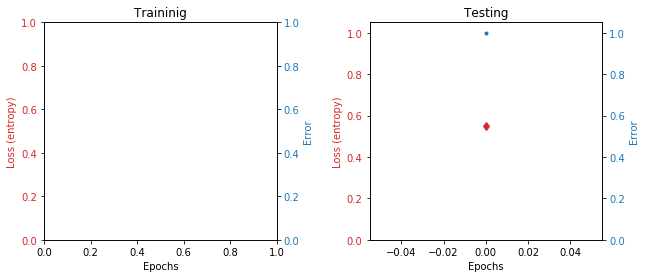

TESTING SET RESULTS: Average loss: 0.4159 Err: 1.0000


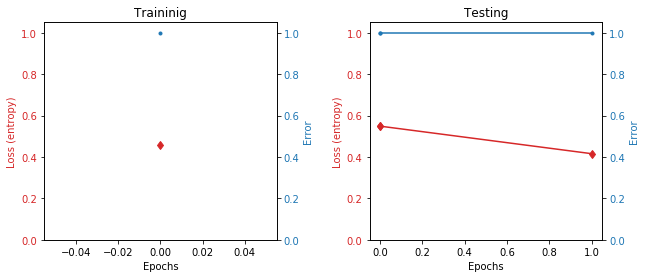

tensor([[2., 1., 1., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 1., 0., 2., 0., 0.],
        [0., 2., 2., 2., 2., 0., 2., 2., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 2., 0., 1., 1., 2., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.3950 Err: 1.0000


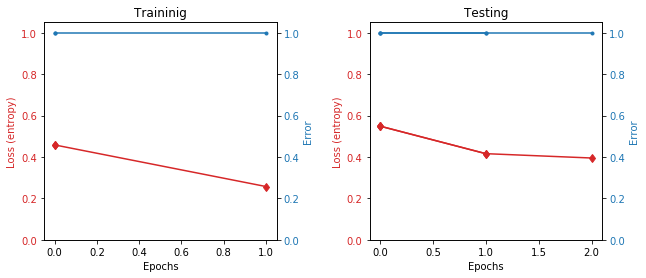

tensor([[2., 2., 2., 0., 2., 0., 1., 2., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 1.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 2., 2.],
        [1., 2., 0., 2., 0., 0., 0., 2., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.3866 Err: 1.0000


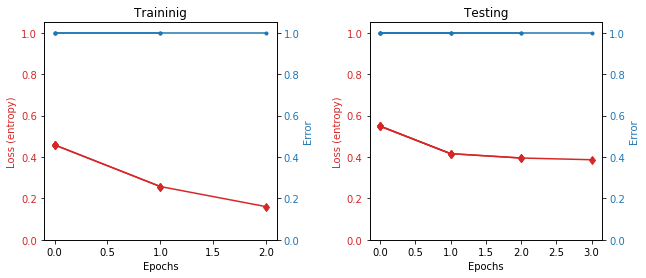

tensor([[2., 1., 2., 0., 2., 0., 1., 2., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 2., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.3916 Err: 1.0000


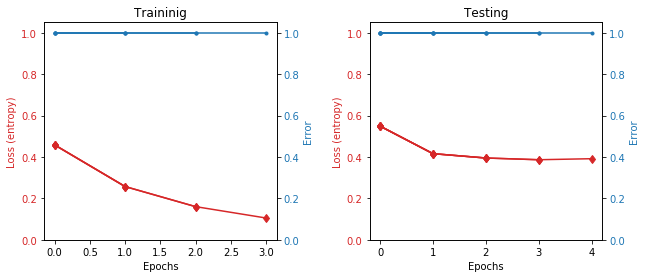

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 2., 2.],
        [2., 2., 0., 0., 2., 0., 0., 2., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.3804 Err: 1.0000


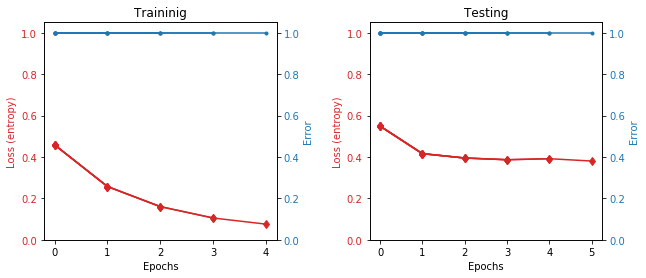

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 2., 2.],
        [2., 2., 0., 0., 2., 0., 0., 2., 2.],
        [1., 2., 0., 2., 0., 0., 0., 2., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.3996 Err: 1.0000


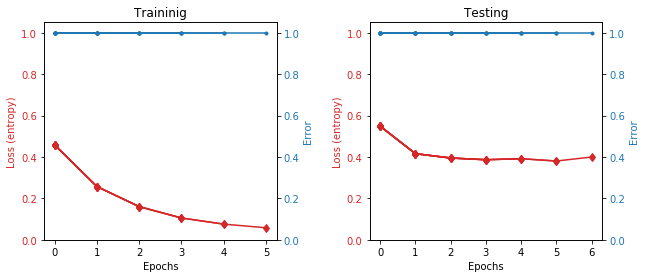

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 2., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 2., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4048 Err: 1.0000


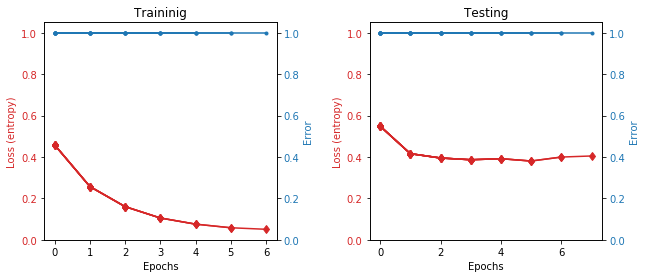

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 1., 0.],
        [2., 0., 1., 2., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 2., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4224 Err: 1.0000


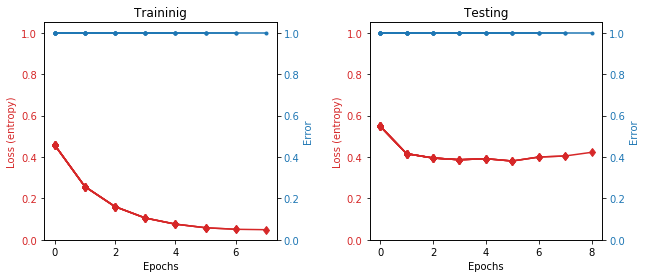

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 2., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 2., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 2., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4202 Err: 1.0000


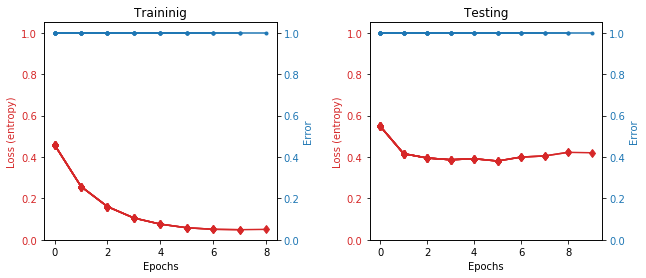

tensor([[2., 1., 2., 0., 2., 0., 1., 2., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 2., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4055 Err: 1.0000


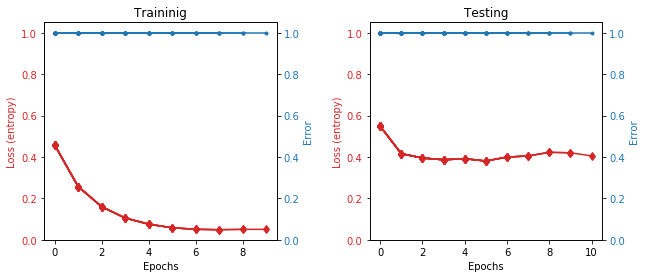

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4105 Err: 1.0000


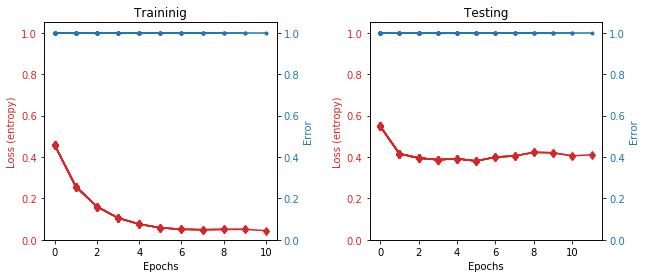

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 2., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4091 Err: 1.0000


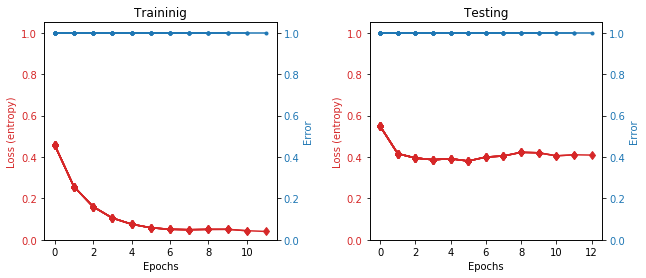

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4184 Err: 1.0000


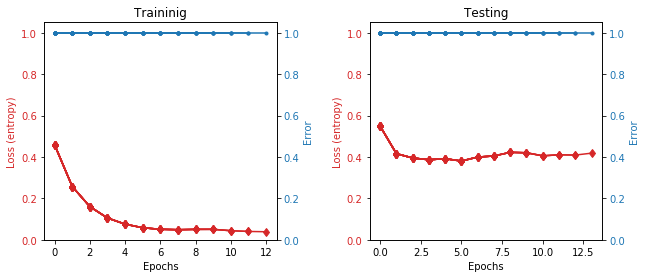

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.3950 Err: 1.0000


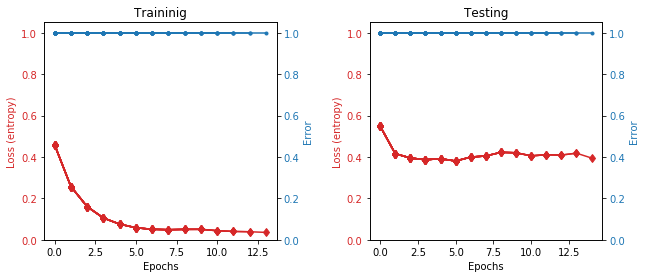

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4030 Err: 1.0000


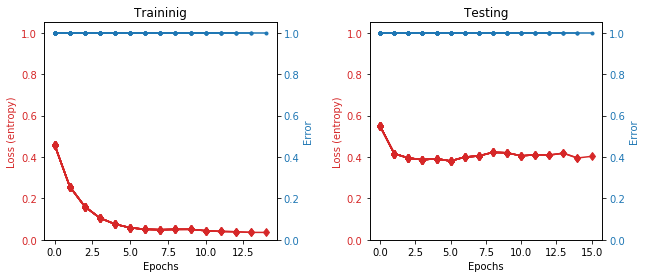

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4023 Err: 1.0000


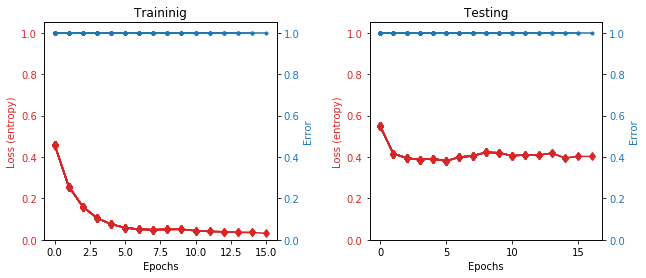

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4078 Err: 1.0000


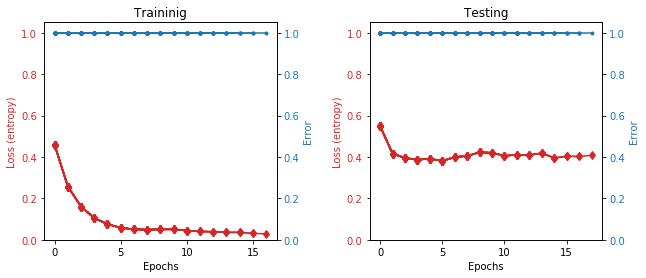

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4152 Err: 1.0000


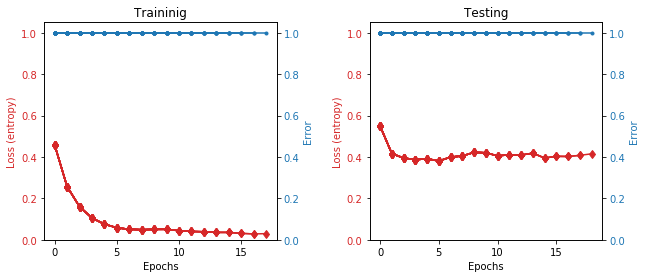

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4261 Err: 1.0000


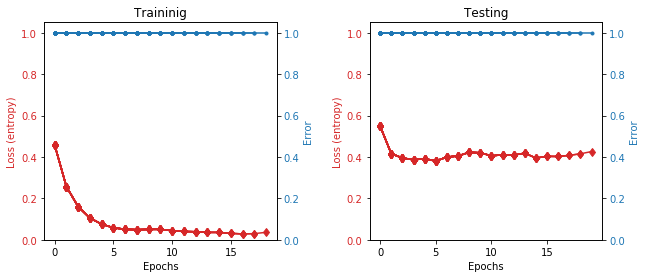

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 2., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4292 Err: 1.0000


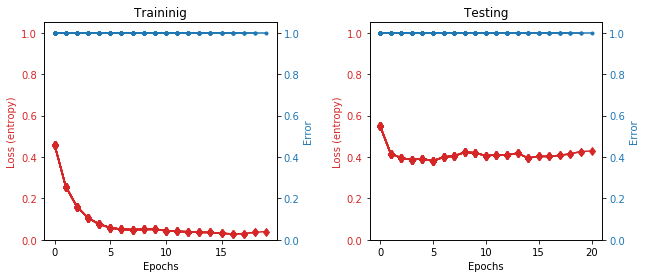

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 2., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 2., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4266 Err: 1.0000


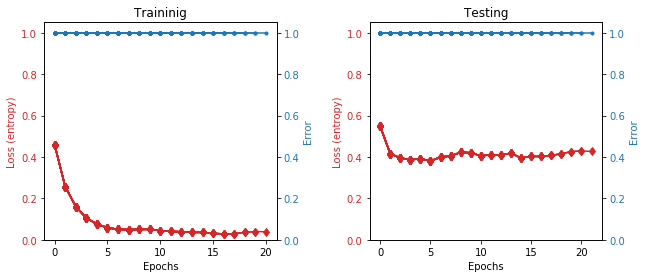

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 2., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 2., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4164 Err: 1.0000


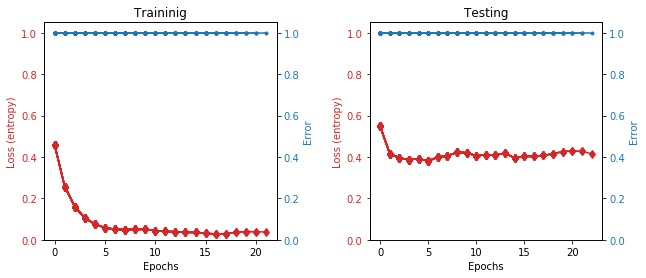

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 2., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 2., 0.],
        [0., 2., 2., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4212 Err: 1.0000


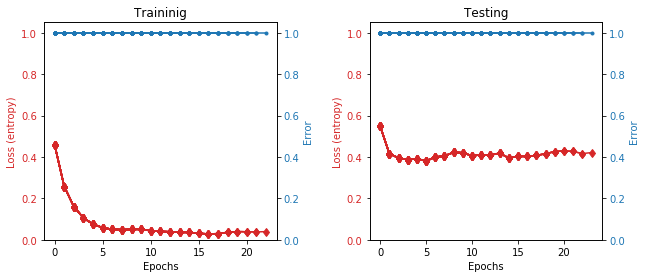

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [1., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 2., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4293 Err: 1.0000


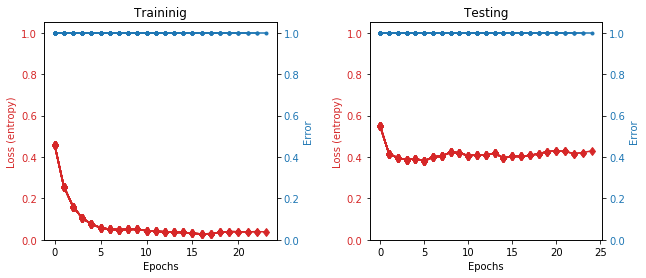

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4244 Err: 1.0000


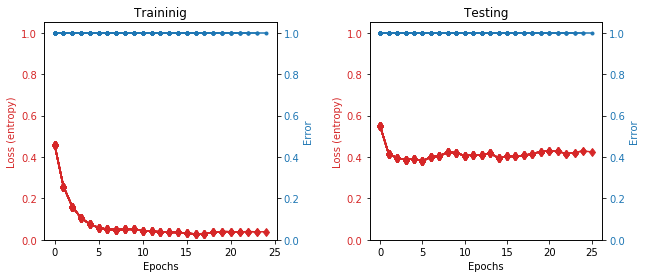

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4211 Err: 1.0000


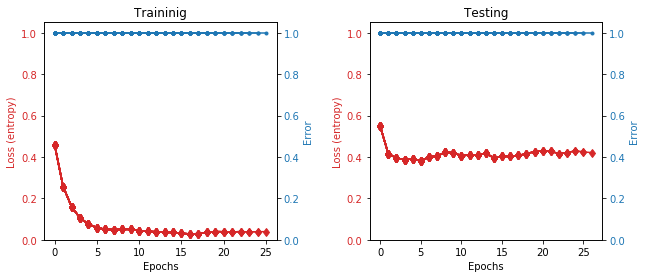

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4167 Err: 1.0000


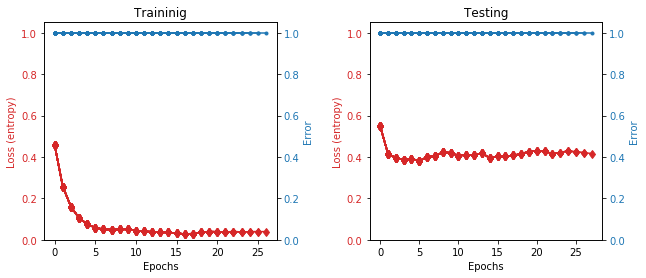

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [2., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4284 Err: 1.0000


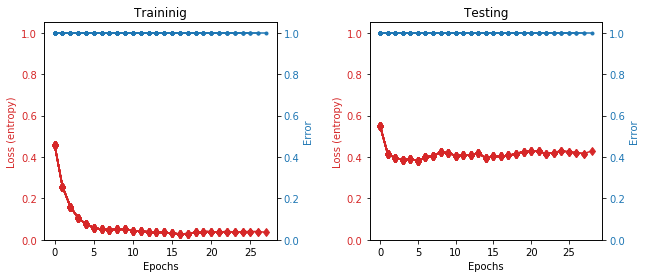

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [2., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4390 Err: 1.0000


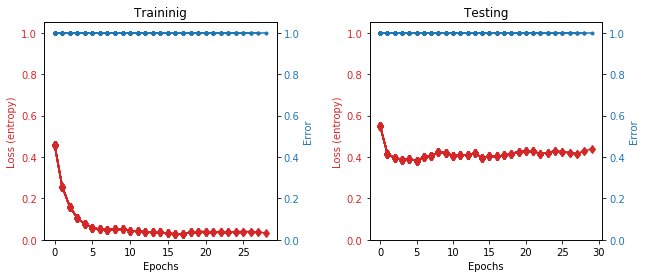

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4252 Err: 1.0000


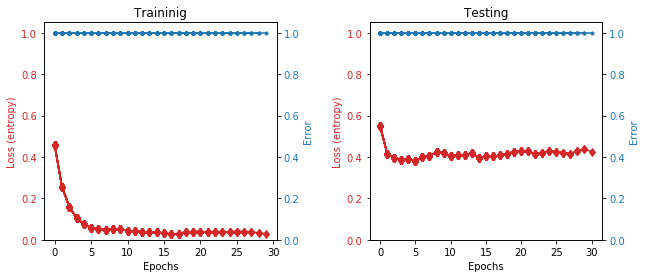

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4274 Err: 1.0000


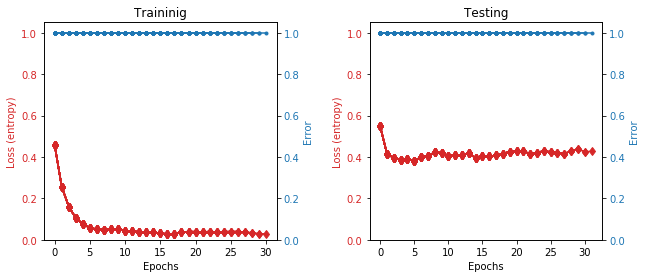

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4243 Err: 1.0000


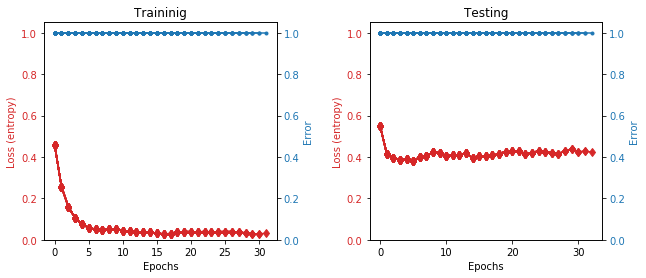

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4208 Err: 1.0000


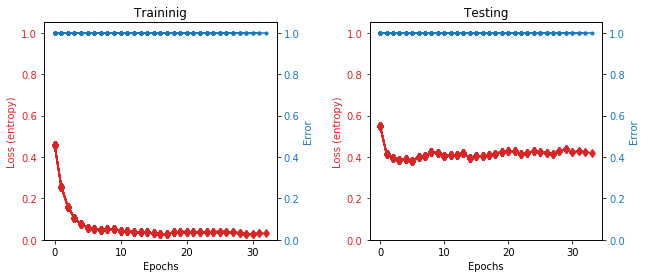

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 2., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4183 Err: 1.0000


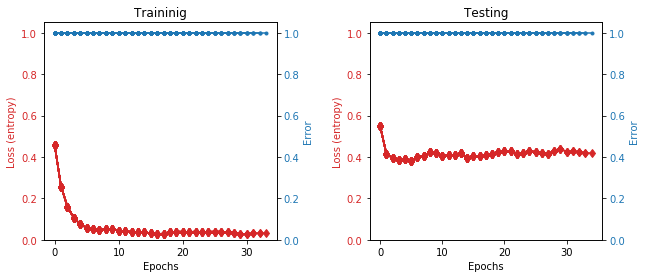

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 2., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 1., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4338 Err: 1.0000


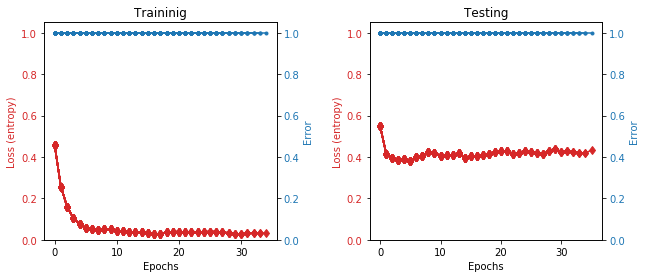

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 2., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4541 Err: 1.0000


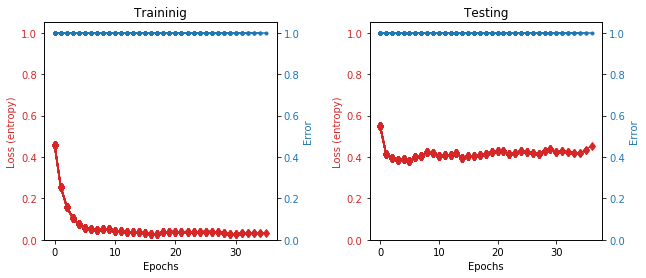

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 2., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4265 Err: 1.0000


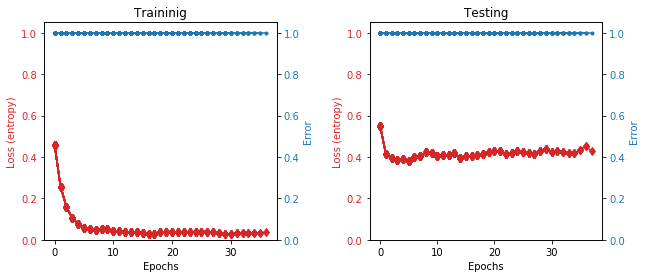

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4211 Err: 1.0000


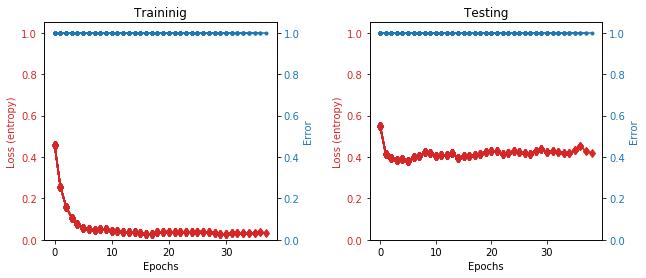

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4303 Err: 1.0000


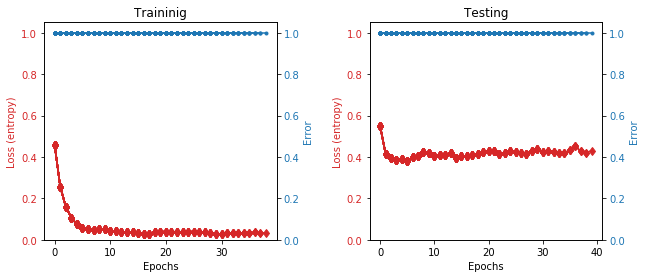

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4138 Err: 1.0000


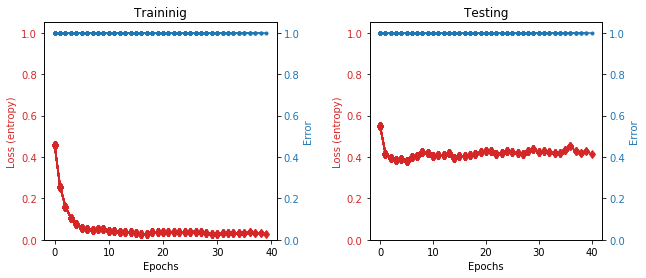

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4511 Err: 1.0000


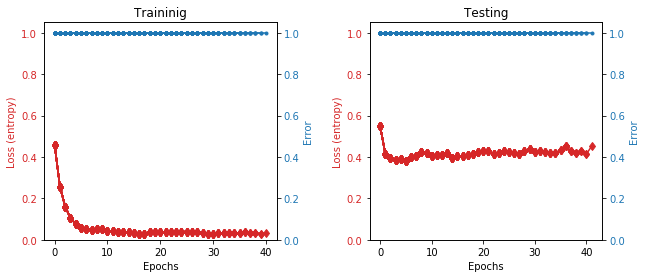

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4213 Err: 1.0000


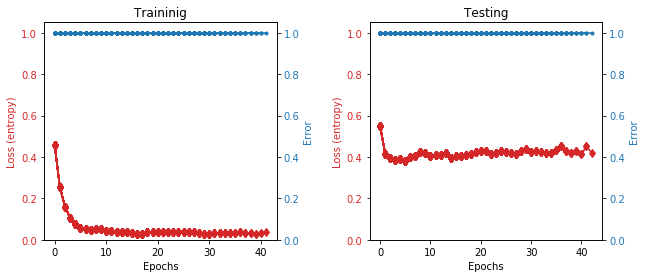

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4269 Err: 1.0000


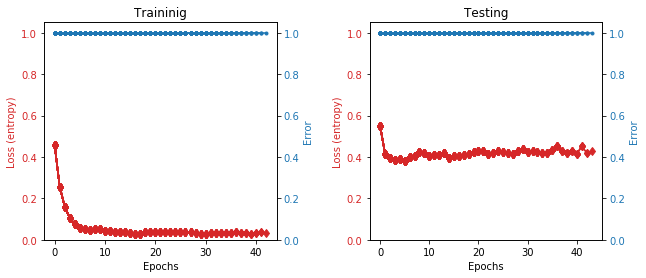

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 2., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4421 Err: 1.0000


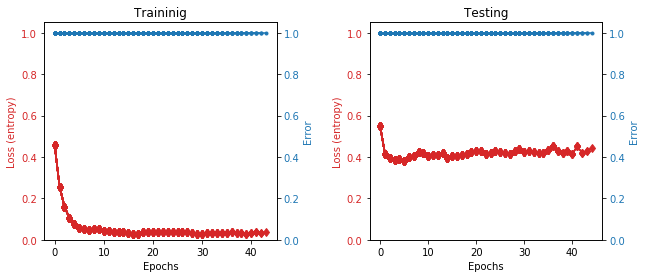

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4314 Err: 1.0000


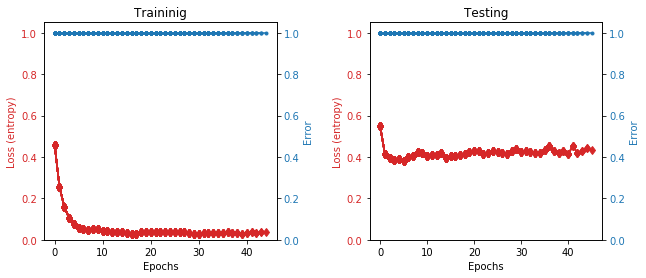

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


TESTING SET RESULTS: Average loss: 0.4642 Err: 1.0000


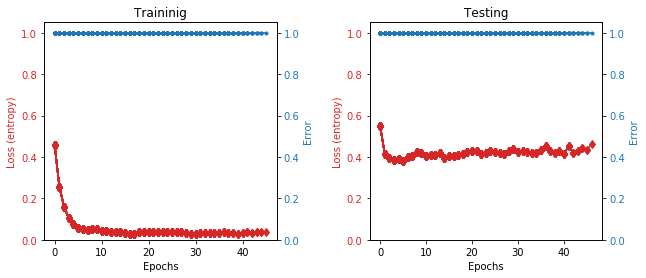

tensor([[2., 1., 2., 0., 2., 0., 1., 1., 0.],
        [0., 0., 2., 1., 2., 1., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 2., 2., 0.],
        [2., 0., 1., 1., 2., 0., 2., 0., 0.],
        [0., 1., 2., 2., 2., 0., 2., 1., 2.],
        [2., 2., 0., 0., 2., 0., 0., 1., 2.],
        [1., 2., 0., 2., 0., 0., 0., 1., 0.],
        [0., 2., 1., 0., 1., 1., 1., 2., 0.]])


KeyboardInterrupt: ignored

In [20]:
our_sudoku_model = SudokuSolver(args.boardSz, args.aux, args.m)
if args.cuda: our_sudoku_model = our_sudoku_model.cuda()

plt.ioff()
optimizer = optim.Adam(our_sudoku_model.parameters(), lr=args.lr)

fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.4)
train_logger = FigLogger(fig, axes[0], 'Traininig')
test_logger = FigLogger(fig, axes[1], 'Testing')

test(args.boardSz, 0, our_sudoku_model, optimizer, test_logger, our_sudoku_test,2)
plt.pause(0.01)
for epoch in range(1, args.nEpoch+1):
    train(args.boardSz, epoch, our_sudoku_model, optimizer, train_logger, our_sudoku_train, 2)
    test(args.boardSz, epoch, our_sudoku_model, optimizer, test_logger, our_sudoku_test, 2)
    display(fig)
    aa=X[10:12]
    bb=is_input[10:12]
    print(transform22(our_sudoku_model.forward(aa,bb)[0],is_input[10]))